In [137]:
import utilities
import importlib
importlib.reload(utilities)

<module 'utilities' from '/global/u2/j/jianyao/foreground/utilities.py'>

In [3]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice

from scipy.stats.mstats import gmean
from multiprocessing import cpu_count

from pathos.pools import ProcessPool as Pool

import copy 

import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

%config Completer.use_jedi = False
%matplotlib inline

# import data

In [24]:
fres = np.array([2.3, 5, 23, 28.4, 33]); nu0 = gmean(fres); nside = 32

nu0_both = gmean(fres)
nu0_C = gmean([fres[1], fres[2], fres[3], fres[4]])
nu0_S = gmean([fres[0], fres[2], fres[3], fres[4]])

In [26]:
print(nu0_S, nu0_C, nu0_both)

14.921826567453781 18.118929287030664 11.990894757722375


In [27]:
P1 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_14.92_s0_32_uK_RJ.npy') ## spass only
P2 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_18.12_s0_32_uK_RJ.npy') ## cbass only
P3= np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy') ## both 

In [28]:
P1/P3

array([0.5189061, 0.5189062, 0.5189061, ..., 0.5189061, 0.5189062,
       0.5189062], dtype=float32)

In [7]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy')#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

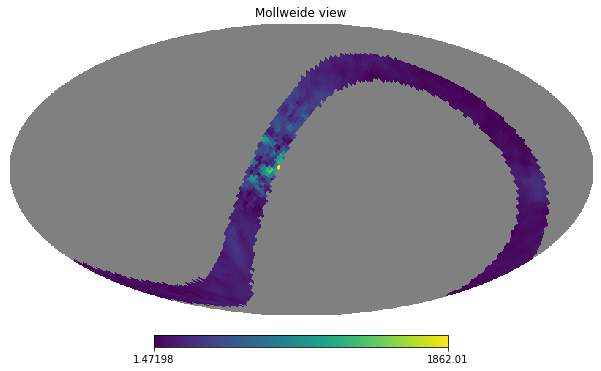

In [245]:
hp.mollview(Mask(P_nu0, mask_both))

# Zero order Modified Bessel Function of the First Kind

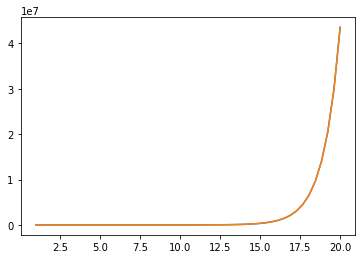

In [25]:
xs = np.linspace(1,20, 50)
plt.plot(xs, Iv(0, xs))
plt.plot(xs, sc.i0(xs))

# likelihood

In [240]:
def Pro(fre, index, A0, beta):
    
    p = total_P[fre][index]; 
    sigma = total_sigma[fre][index] #???????????????
    nu1 = fres[fre]
    
    exp = -(p**2 + (A0*(nu1/nu0)**(beta))**2)/2/sigma**2
    
    x = p*A0*(nu1/nu0)**(beta)/sigma**2
    pro = p/sigma**2*np.exp(exp)*Iv(0, x)
    
    return pro


# using scipy special function **rice** to improving the numerical stability of I0
# https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/_continuous_distns.py#L7220
def Pro_test(fre, index, A0, beta):
    nu1 = fres[fre]
    P = total_P[fre][index]; 
    
    P0 = A0*(nu1/nu0)**(beta)
    sigma = total_sigma[fre][index]
    
    pro = rice.pdf(P, P0/sigma, scale=sigma)
    return pro
    
    
index = 0; nu0 = gmean(fres)

Pro = Pro_test ## use modified pdf instead
def loglikeli(cube):
    A0 = cube[0];
    beta = cube[1];   
    pro0 = Pro(0, index, A0, beta)
    pro1 = Pro(1, index, A0, beta)
    pro2 = Pro(2, index, A0, beta)
    pro3 = Pro(3, index, A0, beta)
    pro4 = Pro(4, index, A0, beta)
    
#     print(pro0, pro1, pro2, pro3, pro4)
    L = (pro0*pro1*pro2*pro3*pro4)
#     print(L)
    if L == 0:
        logL = -1e30
        return logL
    else:
        return np.log(L)

In [241]:
P_nu0[index]

17.77469

In [ ]:
12*64**2

In [246]:
npara = 2; 

def prior(cube):
    A0 = cube[0]*1000 # 0-100
    beta = cube[1]*2 - 4
    
    return [A0, beta]


# Run MC and plot

In [265]:
sampler = dynesty.NestedSampler(loglikeli, prior, npara, nlive=1000, bootstrap = 0)
sampler.run_nested(dlogz = 0.1)
results = sampler.results

iter: 6268 | +1000 | bound: 8 | nc: 1 | ncall: 45196 | eff(%): 16.081 | loglstar:   -inf < -19.346 <    inf | logz: -23.263 +/-    nan | dlogz:  0.000 >  0.100                                       

In [155]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
resamples = dyfunc.resample_equal(samples, weights)

# Results analysis

## S/N

In [32]:
total_P.shape

(5, 12288)

In [317]:
# plt.figure(figsize = (12, 8))
# hp.mollview(total_P[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
# hp.mollview(total_P[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
# hp.mollview(total_P[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
# hp.mollview(total_P[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
# hp.mollview(total_P[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [36]:
total_sigma.shape

(5, 12288)

In [ ]:
# plt.figure(figsize = (12, 8))
# hp.mollview(total_sigma[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
# hp.mollview(total_sigma[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
# hp.mollview(total_sigma[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
# hp.mollview(total_sigma[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
# hp.mollview(total_sigma[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [4]:
S_to_N = (total_P/total_sigma)
S_to_N = hp.ma(S_to_N)
S_to_N.mask = np.logical_not(mask_both)

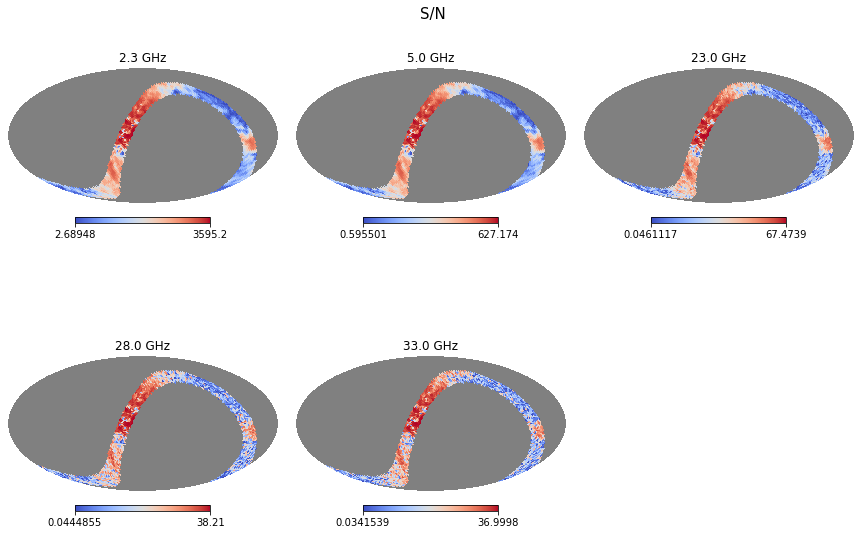

In [222]:
plt.figure(figsize = (12, 8))
plt.title('S/N', fontsize = 15)
plt.axis('off')
hp.mollview(S_to_N[0], norm = 'hist', sub = 231, title = '%s GHz' % fres[0], cmap = 'coolwarm') 
hp.mollview(S_to_N[1], norm = 'hist', sub = 232, title = '%s GHz' % fres[1], cmap = 'coolwarm') 
hp.mollview(S_to_N[2], norm = 'hist', sub = 233, title = '%s GHz' % fres[2], cmap = 'coolwarm') 
hp.mollview(S_to_N[3], norm = 'hist', sub = 234, title = '%s GHz' % fres[3], cmap = 'coolwarm') 
hp.mollview(S_to_N[4], norm = 'hist', sub = 235, title = '%s GHz' % fres[4], cmap = 'coolwarm') 
# hp.graticule()

In [140]:
# hp.cartview(S_to_N[0], norm = 'hist', title = '%s GHz' % fres[0], cmap = 'coolwarm') 

In [141]:
# hp.orthview(S_to_N[0], rot = [-120, 30], norm = 'hist', title = '%s GHz' % fres[0], cmap = 'coolwarm') 

## geometrical mean of S/N

In [116]:
sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

## pick out the overlapped region to a full sky map

In [58]:
Sn_both = sn_both*mask_both; Sn_C = sn_C*mask_both; Sn_S = sn_S*mask_both

In [59]:
np.argsort(Sn_both)[::-1]

array([5957, 6215, 6086, ..., 7763, 7762,    0])

In [167]:
P1[orders].min()

111.79492

## likelihood estimate

In [8]:
low_orders =  np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Low_SNR_pixels_1455.npy')
orders = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/High_SNR_pixels_300.npy')

In [159]:
As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_CBASS.npy')
As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_only.npy')
As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_CBASS_only.npy')

In [160]:
betas_both = utilities.Bp2f(As_betas_both, mask_index, nside = nside)[2]
sig_B_both = utilities.Bp2f(As_betas_both, mask_index, nside = nside)[3]

betas_C = utilities.Bp2f(As_betas_C, mask_index, nside = nside)[2]
sig_B_C = utilities.Bp2f(As_betas_C, mask_index, nside = nside)[3]
betas_S = utilities.Bp2f(As_betas_S, mask_index, nside = nside)[2]
sig_B_S = utilities.Bp2f(As_betas_S, mask_index, nside = nside)[3]

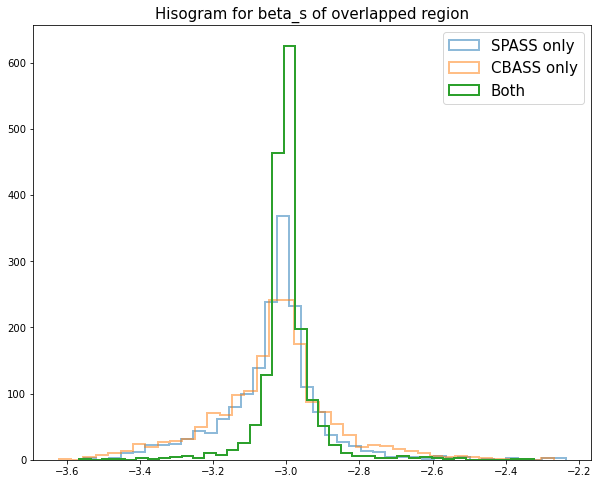

In [161]:
plt.figure(figsize = (10,8))
plt.hist(betas_S[mask_index],  bins = 40, histtype="step", label = 'SPASS only', lw = 2, alpha = 0.5)

plt.hist(betas_C[mask_index], bins = 40, histtype="step" , label = 'CBASS only', lw = 2, alpha = 0.5)

plt.hist(betas_both[mask_index],  bins = 40, histtype="step" , label = 'Both', lw = 2)

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

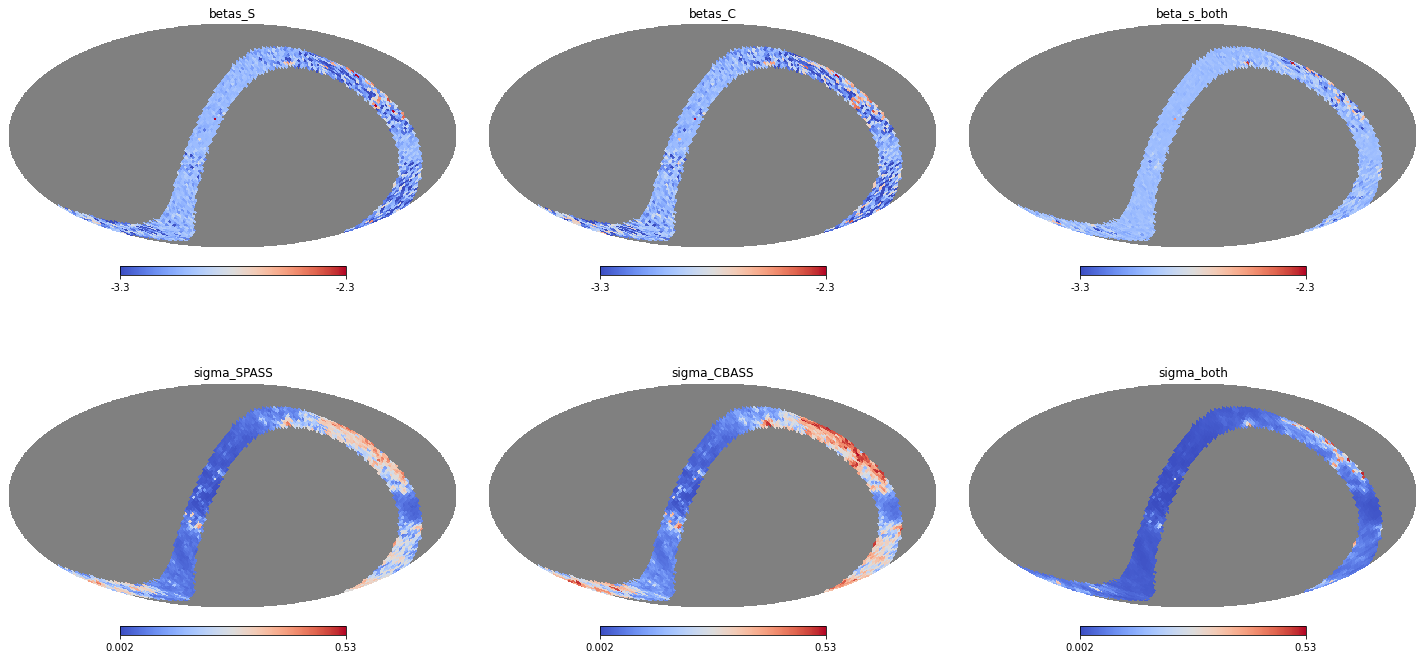

In [178]:
plt.figure(figsize = (20, 10))
hp.mollview(betas_S, cmap = 'coolwarm', sub = 231, title = 'betas_S', min = -3.3, max = -2.3)
hp.mollview(sig_B_S, cmap = 'coolwarm', sub = 234, title = 'sigma_SPASS', min = 0.002, max = 0.53)
# hp.graticule(15)

hp.mollview(betas_C, cmap = 'coolwarm', sub = 232, title = 'betas_C', min = -3.3, max = -2.3)
hp.mollview(sig_B_C, cmap = 'coolwarm', sub = 235, title = 'sigma_CBASS', min = 0.002, max = 0.53)

hp.mollview(betas_both, cmap = 'coolwarm',sub = 233, title = 'beta_s_both', min = -3.3, max = -2.3)
hp.mollview(sig_B_both, cmap = 'coolwarm', sub = 236, title = 'sigma_both', min = 0.002, max = 0.53)

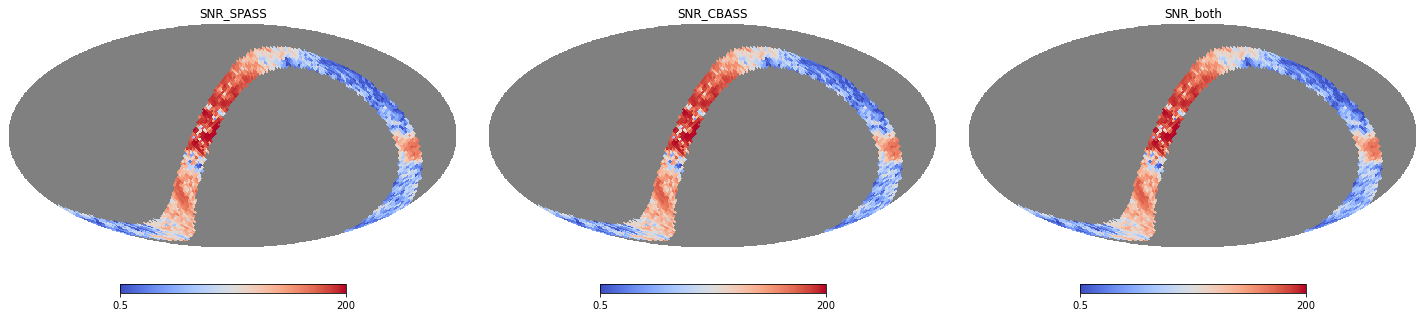

In [177]:
plt.figure(figsize = (20,10))
hp.mollview(Mask(sn_S, mask_both), norm = 'hist', cmap = 'coolwarm',sub = 131, title = 'SNR_SPASS', min = 0.5, max = 200)
hp.mollview(Mask(sn_C, mask_both), norm = 'hist', cmap = 'coolwarm', sub = 132, title = 'SNR_CBASS', min = 0.5, max = 200)
hp.mollview(Mask(sn_both,mask_both), norm = 'hist', cmap = 'coolwarm', sub = 133, title = 'SNR_both', min = 0.5, max = 200)

In [302]:
# plt.figure(figsize = (12, 8))
# plt.title('S/N', fontsize = 15)
# plt.axis('off')
# hp.gnomview(S_to_N[0], rot = [-120, 30], reso =60, norm = 'hist', sub = 231, title = '%s GHz' % fres[0], cmap = 'coolwarm') 
# # hp.graticule()
# hp.gnomview(S_to_N[1], rot = [-120, 30], reso =60, norm = 'hist', sub = 232, title = '%s GHz' % fres[1], cmap = 'coolwarm') 
# hp.gnomview(S_to_N[2], rot = [-120, 30], reso =60, norm = 'hist', sub = 233, title = '%s GHz' % fres[2], cmap = 'coolwarm') 
# hp.gnomview(S_to_N[3], rot = [-120, 30], reso =60, norm = 'hist', sub = 234, title = '%s GHz' % fres[3], cmap = 'coolwarm') 
# hp.gnomview(S_to_N[4], rot = [-120, 30], reso =60, norm = 'hist', sub = 235, title = '%s GHz' % fres[4], cmap = 'coolwarm') 

## 2d of betas and S/N

Text(0.5, 0, '$log_{10}(S/N)$, Geometric mean')

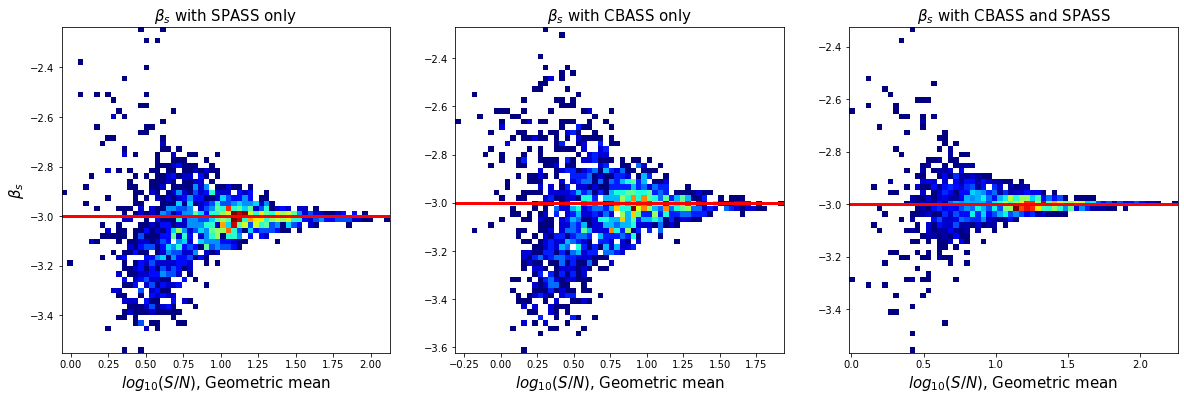

In [163]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

x0, y0 = sn_S[mask_index], betas_S[mask_index]
ax[0].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[0].set_title(r'$\beta_s$ with SPASS only', fontsize = 15)
ax[0].axhline(-3.0, c = 'red', lw = 3)
ax[0].set_ylabel(r'$\beta_s$', fontsize = 15)
ax[0].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_C[mask_index], betas_C[mask_index]
ax[1].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[1].set_title(r'$\beta_s$ with CBASS only', fontsize = 15)
ax[1].axhline(-3.0, c = 'red', lw = 3)
ax[1].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)

x0, y0 = sn_both[mask_index], betas_both[mask_index]
ax[2].hist2d(np.log10(x0),y0, bins = 60, cmap = my_cmap, cmin = 1) #cmap = plt.cm.GnBu
ax[2].set_title(r'$\beta_s$ with CBASS and SPASS', fontsize = 15)
ax[2].axhline(-3.0, c = 'red', lw = 3)
# ax[2].set_xlim(0,2.4)
ax[2].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
# fig.colorbar(h)

## high SNR regions -- user more chains in MCMC

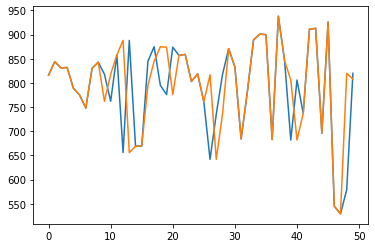

In [34]:
plt.plot(np.argsort(Sn_both[mask_index])[::-1][0:50])
plt.plot(np.argsort(Sn_S[mask_index])[::-1][0:50])

In [65]:
orders = (np.argsort(Sn_S)[::-1])[0:300]

In [239]:
low_orders = (np.argsort(Sn_S)[::-1])[300:1755]

In [243]:
np.save('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Low_SNR_pixels_1455.npy', low_orders)

In [307]:
low_snr = np.zeros(49*30, dtype = int)
low_snr[0:1455] = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Low_SNR_pixels_1455.npy')
np.save('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Low_SNR_pixels_1470.npy', low_snr)

In [308]:
low_orders

array([2233, 6795, 6539, ..., 1943, 4367, 3602])

In [79]:
P_nu0[low_orders]

array([277.05173  , 208.31929  , 245.2653   , ...,   3.5463948,
        21.286764 ,   7.6440535], dtype=float32)

In [157]:
P3[orders]

array([1862.014  , 1385.1987 , 1311.2368 , 1231.4127 , 1201.2201 ,
       1159.9038 , 1130.7448 , 1091.4183 , 1044.7352 , 1021.3548 ,
       1035.8247 , 1075.4854 , 1001.5075 , 1007.7231 ,  958.1717 ,
       1043.0186 ,  914.1289 ,  950.12024,  975.5708 ,  890.85596,
        914.8201 ,  855.0504 ,  862.5965 ,  873.5174 ,  833.7813 ,
        827.4962 ,  772.1207 ,  829.2788 ,  818.83167,  758.3351 ,
        814.4586 ,  761.15643,  740.09174,  760.6294 ,  763.0811 ,
        739.43176,  689.60736,  652.2957 ,  651.31415,  635.0096 ,
        648.06683,  626.1607 ,  625.13983,  609.8925 ,  626.4537 ,
        603.4343 ,  599.3457 ,  574.3187 ,  581.0885 ,  532.5656 ,
        618.88654,  616.57367,  530.8983 ,  521.8995 ,  519.87555,
        571.6034 ,  553.3269 ,  509.587  ,  553.56964,  540.17175,
        473.37305,  522.7019 ,  509.64758,  473.77185,  499.7269 ,
        479.18378,  455.13477,  521.8908 ,  499.49783,  466.40353,
        503.24078,  440.5468 ,  472.1931 ,  415.64905,  506.10

In [156]:
P1[orders]

array([966.21045 , 718.7881  , 680.4088  , 638.9876  , 623.3205  ,
       601.8812  , 586.7504  , 566.3436  , 542.1195  , 529.98724 ,
       537.49585 , 558.076   , 519.6884  , 522.9137  , 497.20114 ,
       541.22876 , 474.34708 , 493.02325 , 506.2297  , 462.27063 ,
       474.70578 , 443.6909  , 447.6066  , 453.27356 , 432.6542  ,
       429.39285 , 400.65817 , 430.31784 , 424.8968  , 393.50473 ,
       422.6276  , 394.96878 , 384.03818 , 394.69525 , 395.9675  ,
       383.6957  , 357.84152 , 338.48026 , 337.97092 , 329.51038 ,
       336.2859  , 324.91867 , 324.3889  , 316.47696 , 325.0707  ,
       313.1258  , 311.00418 , 298.01752 , 301.5304  , 276.35156 ,
       321.14404 , 319.94388 , 275.48642 , 270.81683 , 269.7666  ,
       296.6085  , 287.12476 , 264.42783 , 287.2507  , 280.29843 ,
       245.63617 , 271.2332  , 264.45926 , 245.84311 , 259.31134 ,
       248.65141 , 236.17223 , 270.81235 , 259.1925  , 242.01965 ,
       261.13474 , 228.60245 , 245.02391 , 215.68283 , 262.621

In [158]:
P2[orders].min()

62.443962

In [309]:
low_snr

array([2233, 6795, 6539, ...,    0,    0,    0])

In [89]:
Sn_S_L = np.zeros(12*nside**2)

Sn_S_L[orders] = Sn_S[orders]

## combine low SNR pixels with High SNR pixels

## Noise realizations

In [177]:
noise_0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_noise_32_uK_RJ_000.npy')

In [181]:
noise_0[0][1][5829]

-27.74107209649451

In [183]:
np.mean(noise_0[0][2])

0.2891483066216381

In [153]:
# a = []; b = []
a.append(1); b.append(2);
c = np.array((a,b))

In [155]:
c = np.array((np.array(a),np.array(b)))

In [159]:
c[0][0]

1

# test

In [45]:
n = 480
def ppp(n):
    for i in range(5):
        print(total_P[i][n],total_sigma[i][n], total_P[i][n]/total_sigma[i][n])
    return None

In [36]:
import Loglikeli

In [79]:
import importlib
importlib.reload(Loglikeli)

<module 'Loglikeli' from '/global/u2/j/jianyao/foreground/Loglikeli.py'>

In [94]:
npara = 2; 

def prior(cube):
    As = cube[0]*500
    beta = cube[1]*2 - 4
    
    return [As, beta]

def prior_flex(cube, A0):
    
    As = cube[0]*200 + (A0 - 100)
    beta = cube[1]*2 - 4
    
    return [As, beta]

In [93]:
frelist = [0,1,2,3,4]
logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, 5957)

In [102]:
# with Pool(cpu_count()-1) as executor:
        
#     sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=200, pool=executor, queue_size=cpu_count(), bootstrap = 0)
#     sampler.run_nested(dlogz = 0.1)
#     results = sampler.results

In [101]:
P_nu0[logL.index]

1862.014

In [ ]:
sampler = dynesty.NestedSampler(logL.loglike, prior_flex, npara, nlive=400, ptform_args = (P_nu0[logL.index],), bootstrap = 0)
sampler.run_nested(dlogz = 0.5)
results = sampler.results

1553it [01:16, 20.22it/s, +200 | bound: 169 | nc: 1 | ncall: 94689 | eff(%):  1.851 | loglstar:   -inf < -16.940 <    inf | logz: -23.818 +/-    nan | dlogz:  0.002 >  0.500]


Text(0.5, 0.98, 'Pixel 5957')

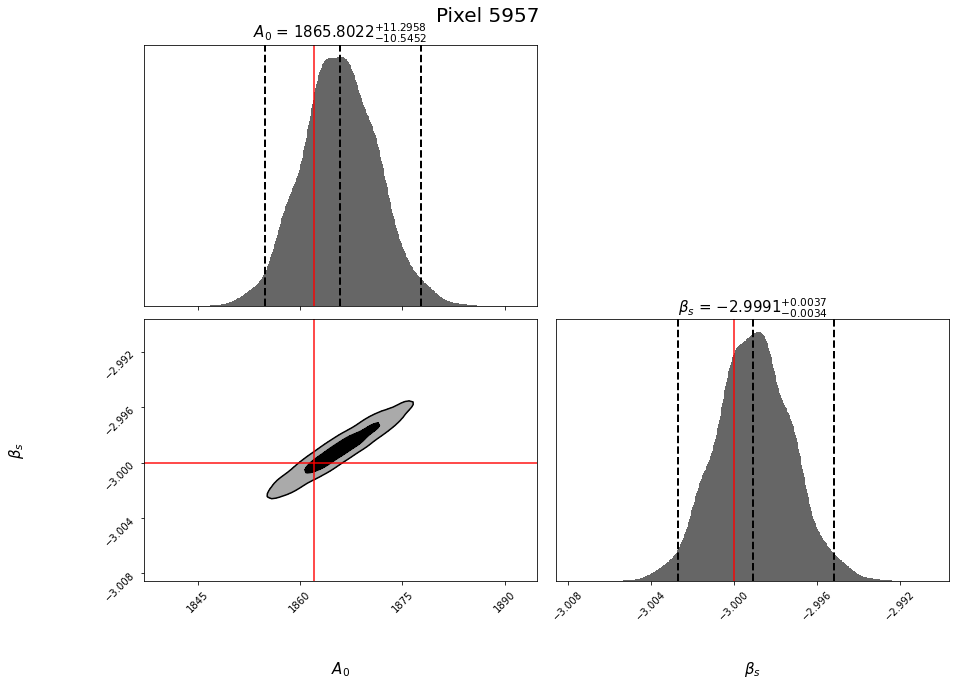

In [48]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

In [81]:
from dynesty import utils as dyfunc

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [283]:
quantiles = [dyfunc.quantile(samps, sig2, weights=weights)
             for samps in samples.T]

In [285]:
quantiles[1]

[-3.0163537971151095, -2.9965625272311702, -2.9774114631902466]

In [284]:
np.diff(quantiles[1])

array([0.01979127, 0.01915106])

In [ ]:
ql, qm, qh 

In [ ]:
q_minus, q_plus = qm - ql, qh - qm

In [86]:
As, beta_s = mean[0], mean[1]

In [88]:
beta_s

-2.870317931108974

In [90]:
np.sqrt(cov)

array([[6.42736638, 0.72985225],
       [0.72985225, 0.08362463]])

In [292]:
np.sqrt(cov[1,1])

0.009645901932771858

Text(0.5, 0.98, 'Pixel 3520')

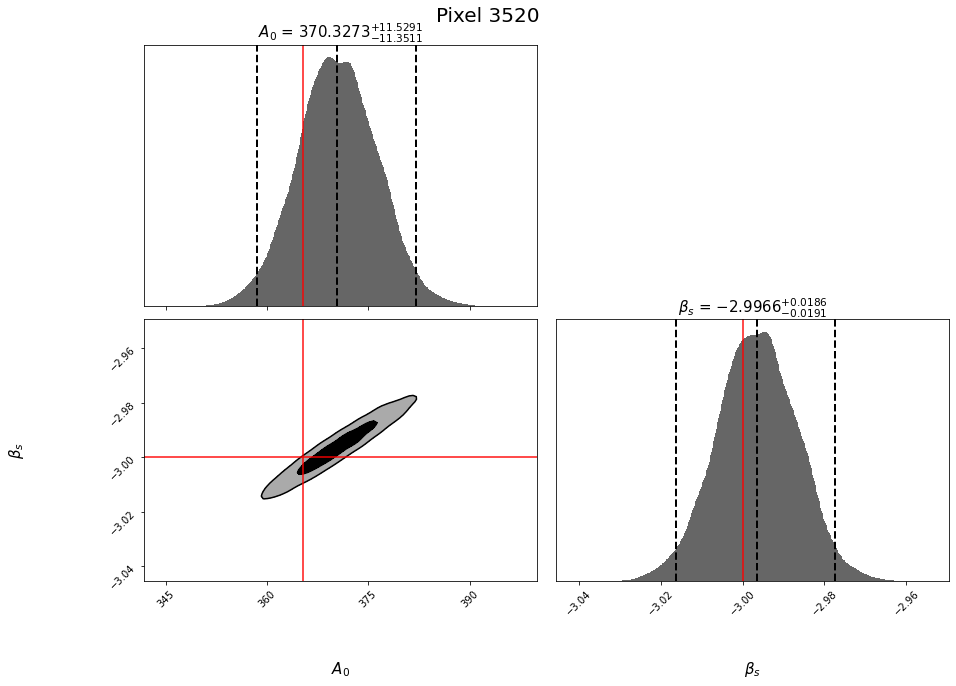

In [288]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

In [37]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])

In [38]:
dynesty.utils.quantile(samples[:,1], [0.5], weights)

[-3.0100064555853367]

In [206]:
dynesty.utils.quantile(samples[:,0], sig2, weights)

[42.51413064803956, 64.39738969437843, 88.79334606500959]

In [260]:
a = np.array([0,1,2,3,4])

In [263]:
frelist = [1,2,3]

In [264]:
a[frelist]

array([1, 2, 3])

In [508]:
from scipy import stats
stats.norm.ppf(0.95, loc =0, scale = 1)

1.6448536269514722